In [530]:
class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
                
        transient = ((self._rho*self._cp*self._grid.vol)*(self._T[1:-1] - self._Told[1:-1]))/self._dt
        
        # Calculate the linearization coefficients
        coeffP = (self._rho*self._cp*self._grid.vol)/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transient)

        return coeffs

In [531]:
class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, T_inf, loc, ha, k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            T_inf........ Ambient Temperature
            ha is the convective heat transfer coefficient
            loc ........ boundary location
            k.......thermal conductivity
        """
        self._phi = phi
        self._grid = grid
        self._T_inf = T_inf
        self._ha = ha
        self._k = k
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            return ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1 /(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + (self._grid.dx_WP[0]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_WP[0]*(self._ha/self._k)))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = ( self._phi[-2] + (self._grid.dx_PE[-1]*(self._ha/self._k)*self._T_inf))/(1 + (self._grid.dx_PE[-1]*(self._ha/self._k)))
        else:
            raise ValueError("Unknown boundary location")

In [532]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature Function 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191    #ConstantC1
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)         
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    
    dt1 = dt
    T_solns.append(np.copy(T))
    


Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.6608936448392342e-13; Avg. Resid. = 7.152056724635259e-14
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 2.8988545320331833; Avg. Resid. = 2.5573262107559507
Iteration = 1; Max. Resid. = 9.170442183403793e-14; Avg. Resid. = 3.126388037344441e-14


In [533]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error1 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


[19.22932462 19.22932462 19.08714452 18.80383572 18.38149323 17.82324016
 17.1332046  16.31648909 15.3791328  14.32806685 13.17106298 12.5438695 ]


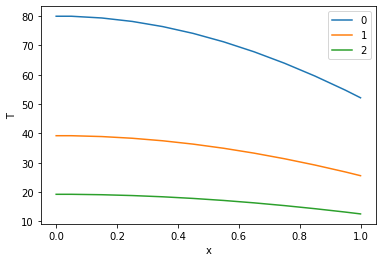

In [534]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1
print(T)
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [535]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    dt2 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.509903313490213e-13; Avg. Resid. = 7.278622149442527e-14
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 3.8898868479662942; Avg. Resid. = 3.431480242211589
Iteration = 1; Max. Resid. = 9.85878045867139e-14; Avg. Resid. = 5.553335569175033e-14
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 2.559986962812743; Avg. Resid. = 2.2585280016599447
Iteration = 1; Max. Resid. = 7.549516567451064e-14; Avg. Resid. = 3.5016434196677435e-14
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 1.6848795729008257; Avg. Resid. = 1.4865001020622892
Iteration = 1; Max. Resid. = 3.430589146091734e-14; Avg. Resid. = 1.844080443902385e-14


In [536]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error2 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


In [537]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.3512125
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1


# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    dt3 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.8047124999999999
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.5365486660812167e-13; Avg. Resid. = 9.241496456979803e-14
Timestep = 1; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 4.692018122552212; Avg. Resid. = 4.138843752758117
Iteration = 1; Max. Resid. = 5.684341886080802e-14; Avg. Resid. = 2.9132252166164105e-14
Timestep = 2; Time = 1.5071374999999998
Iteration = 0; Max. Resid. = 3.7243477596597776; Avg. Resid. = 3.285683361483618
Iteration = 1; Max. Resid. = 7.815970093361102e-14; Avg. Resid. = 3.7836400679225336e-14
Timestep = 3; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 2.9564785414947887; Avg. Resid. = 2.608355116708691
Iteration = 1; Max. Resid. = 5.861977570020827e-14; Avg. Resid. = 2.788880237858393e-14
Timestep = 4; Time = 2.2095624999999997
Iteration = 0; Max. Resid. = 2.346983980675325; Avg. Resid. = 2.070648988563958
Iteration = 1; Max. Resid. = 5.5289106626332

In [538]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error3 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


In [539]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.175606
time = 0.4535
value = [0.8047, 1.1559, 1.507, 1.85, 2.209, 2.56, 2.91, 3.2632]
# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
Texact = []

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    dt4 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.629106
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.8740564655672642e-13; Avg. Resid. = 7.238654120556021e-14
Timestep = 1; Time = 0.8047120000000001
Iteration = 0; Max. Resid. = 5.231596708097043; Avg. Resid. = 4.614425437536791
Iteration = 1; Max. Resid. = 9.50350909079134e-14; Avg. Resid. = 3.4061642395499804e-14
Timestep = 2; Time = 0.9803180000000001
Iteration = 0; Max. Resid. = 4.629790507764539; Avg. Resid. = 4.0842285387921855
Iteration = 1; Max. Resid. = 7.815970093361102e-14; Avg. Resid. = 4.591882429849648e-14
Timestep = 3; Time = 1.1559240000000002
Iteration = 0; Max. Resid. = 4.097487996205159; Avg. Resid. = 3.61489820597917
Iteration = 1; Max. Resid. = 1.1191048088221578e-13; Avg. Resid. = 5.706546346573305e-14
Timestep = 4; Time = 1.33153
Iteration = 0; Max. Resid. = 3.6265166969856457; Avg. Resid. = 3.1994851303362113
Iteration = 1; Max. Resid. = 1.2656542480726785e-13; Avg. Resid. =

In [540]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error4 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


In [541]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.0878
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1


# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial temperature 
T1 = 0
Ti = 100
Zi = 0.8603    #Eigenvalue
C1 = 1.1191
L = 1
T2 = (100*(C1*np.exp(-Zi**2*(time))*np.cos(Zi*grid.xP/L)) + T1)
T = T2*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha , k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)
        
        
        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    dt5 = dt
    T_solns.append(np.copy(T))

Timestep = 0; Time = 0.5413
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 1.5587531265737198e-13; Avg. Resid. = 6.727951529228449e-14
Timestep = 1; Time = 0.6291
Iteration = 0; Max. Resid. = 5.550976956865838; Avg. Resid. = 4.89566880981793
Iteration = 1; Max. Resid. = 1.7674750552032492e-13; Avg. Resid. = 6.106226635438361e-14
Timestep = 2; Time = 0.7169
Iteration = 0; Max. Resid. = 5.211992726673173; Avg. Resid. = 4.597341517975944
Iteration = 1; Max. Resid. = 8.348877145181177e-14; Avg. Resid. = 3.206324095117452e-14
Timestep = 3; Time = 0.8047
Iteration = 0; Max. Resid. = 4.893862074355723; Avg. Resid. = 4.317134191234427
Iteration = 1; Max. Resid. = 1.0036416142611415e-13; Avg. Resid. = 3.1530333899354446e-14
Timestep = 4; Time = 0.8925
Iteration = 0; Max. Resid. = 4.595296925153817; Avg. Resid. = 4.053982262420487
Iteration = 1; Max. Resid. = 1.0391687510491465e-13; Avg. Resid. = 5.226929999935237e-14
Timestep = 5; Tim

In [542]:
Tex = np.ones(grid.ncv+2)
for i in range(ncv+2):
    Tex[i] = ((100*(1.1191*np.exp(-0.8603**2*(3.2635))*np.cos(0.8603*grid.xP[i]/L)))) 
Error =  T[1:-1] - Tex[1:-1]
E_bar = sum(Error)/grid.ncv
print(Tex)

Error5 = E_bar

[9.99741058 9.98816295 9.91428453 9.76707414 9.54762064 9.25754723
 8.89899948 8.4746294  7.98757591 7.44144154 6.84026582 6.52041201]


The slope is [0.8832241061924297, 0.9359876696858631, 0.9592424459665247, 0.9605247217886043]


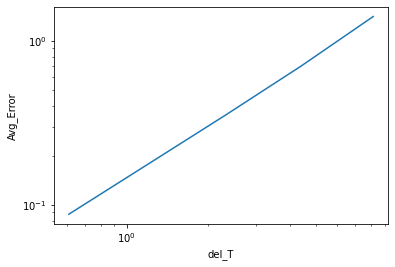

In [580]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

Avg_Error = [Error1, Error2, Error3, Error4, Error5]
del_T = [dt1, dt2, dt3, dt4, dt5]

# Calculating the slope p for first order transient model
Error_1 = np.log(Error1)
Error_2 = np.log(Error2)
Error_3 = np.log(Error3)
Error_4 = np.log(Error4)
Error_5 = np.log(Error5)

dt_1 = np.log(dt1)
dt_2 = np.log(dt2)
dt_3 = np.log(dt3)
dt_4 = np.log(dt4)
dt_5 = np.log(dt5)

plt.loglog((Avg_Error), (del_T))
slope = [(Error_2-Error_1)/(dt_2-dt_1), (Error_3-Error_2)/(dt_3-dt_2), (Error_4-Error_3)/(dt_4-dt_3), (Error_5-Error_4)/(dt_5-dt_4) ]

print('The slope is', slope)

plt.xlabel("del_T")
plt.ylabel("Avg_Error")
plt.show()

In [ ]:
class SecondOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, Told2, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._Told2 = Told2
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        
        transient = ((self._rho*self._cp*self._grid.vol)*(1.5*self._T[1:-1] - 2*self._Told[1:-1] + 0.5*self._Told2[1:-1]))/self._dt
        
        # Calculate the linearization coefficients
        coeffP = (1.5*(self._rho*self._cp*self._grid.vol))/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transient)

        return coeffs

In [ ]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 10
dt = 0.28
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 0
Ti = 100
Zi = 0.8603
C1 = 1.1191
L = 1
#x = np.arange(0,1,.09)
# Initialize field variable arrays
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
#((80*np.cos(0.8603*x)) + 273)
T = T2*np.ones(grid.ncv+2)
#np.ones(grid.ncv+2)*(((Ti-T1)*(C1*exp(-(Zi**2)*(0.4535))*cos(Zi*x/L)) + T1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 0, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    #print(T)
    T_solns.append(np.copy(T))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()

In [ ]:
class DiffusionModel_CrankNicolson:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc, w):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._w = w
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = self._w*(flux_e - flux_w)
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [ ]:
#crank
class SecondOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, Told2, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._Told2 = Told2
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        
        transient = ((self._rho*self._cp*self._grid.vol)*(1.5*self._T[1:-1] - 2*self._Told[1:-1] + 0.5*self._Told2[1:-1]))/self._dt
        
        # Calculate the linearization coefficients
        coeffP = (1.5*(self._rho*self._cp*self._grid.vol))/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transient)

        return coeffs

In [ ]:
from Lesson3.Grid import Grid
from Lesson3.ScalarCoeffs import ScalarCoeffs
from Lesson3.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson3.Models import DiffusionModel, SurfaceConvectionModel
from Lesson3.LinearSolver import solve

import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1
lz = 1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 10
dt = 0.28
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
ha = 1
To = 283
w = 0.5
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions

T1 = 273
Ti = 373
Zi = 0.8603
C1 = 1.1191
L = 1
#x = np.arange(0,1,.09)
# Initialize field variable arrays
T2 = (100*(C1*np.exp((-Zi**2)*(time))*np.cos(Zi*grid.xP/L)) + T1)
#((80*np.cos(0.8603*x)) + 273)
T = T2*np.ones(grid.ncv+2)
#np.ones(grid.ncv+2)*(((Ti-T1)*(C1*exp(-(Zi**2)*(0.4535))*cos(Zi*x/L)) + T1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, 273, BoundaryLocation.EAST, ha, k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
Told2 = np.copy(T)
transient = SecondOrderTransientModel(grid, T, Told, Told2, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel_CrankNicolson(grid, T, k, west_bc, east_bc, w)

# Define the surface convection model
#surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
    
#Told2[:] = [:]
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told2[:] = Told[:]
    Told[:] = T[:]
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        #coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
        #Storing The temp for Told2
          
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
        
    # Store the solution
    print(T)
    T_solns.append(np.copy(T))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()